<center>


## Redes Neuronales avanzadas para el aprendizaje profundo

---


### Matías Palma Manterola
####  11 de abril del 2022

La Base de Datos twitter training contiene 4 columnas: código, entidad,
sentimiento, opinión. Solo considerando las columnas sentimiento y opinión,
y utilizando las buenas prácticas del análisis de datos, encontrar un modelo de
Análisis de Sentimientos para entidades en redes sociales. Para esto, resolver
las siguientes preguntas.

# Pregunta 1
Preprocesar los datos y construir un conjunto de datos $(X, y)$, donde $y\in\{Positive, Negative\}$. Aquí, la variable $X$ corresponde al conjunto de documentos vectorizados y la variable $y$ corresponde a las etiquetas de clase representadas como vectores categóricos.

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
twitter_coms =  pd.read_csv(r'/content/gdrive/MyDrive/twitter_training.csv', 
                            names = ['code','entity','sentiment','opinion'])
twitter_coms.shape

(74682, 4)

Contamos la cantidad de datos que existen en cada clase

In [3]:
from collections import Counter
classes = Counter(twitter_coms['sentiment'])
classes

Counter({'Irrelevant': 12990,
         'Negative': 22542,
         'Neutral': 18318,
         'Positive': 20832})

Consultamos los datos nulos existentes en cada columna

In [4]:
twitter_coms.isnull().sum()

code           0
entity         0
sentiment      0
opinion      686
dtype: int64

Eliminamos los valores nulos de la columna *opinion*

In [5]:
twitter_coms = twitter_coms.dropna(subset=['opinion']).reset_index(drop = True)

Consultamos aquellos comentarios vacíos

In [6]:
twitter_coms.query("opinion == ' '")

,code,entity,sentiment,opinion
2286,1602,CallOfDutyBlackopsColdWar,Irrelevant,
2979,1719,CallOfDutyBlackopsColdWar,Positive,
3220,1763,CallOfDutyBlackopsColdWar,Neutral,
3908,1880,CallOfDutyBlackopsColdWar,Negative,
4198,1929,CallOfDutyBlackopsColdWar,Negative,
...,...,...,...,...
72563,8945,Nvidia,Positive,
72846,8993,Nvidia,Neutral,
73082,9036,Nvidia,Negative,
73288,9073,Nvidia,Positive,


Reemplazamos los comentarios vacíos por valores nulos para eliminarlos del dataframe

In [7]:
import numpy as np

twitter_coms['opinion'] = twitter_coms.opinion.replace(' ', np.NaN )
twitter_coms = twitter_coms.dropna(subset=['opinion']).reset_index(drop = True)

Transformamos las clases positiva(1) y negativa(0) a binario y extraemos los datos de interés en la variable binary_coms

In [8]:
twitter_coms['sentiment'] = twitter_coms['sentiment'].replace({'Positive':1 , 'Negative':0})
binary_coms = twitter_coms.query("sentiment == 1 or sentiment == 0").reset_index(drop=True)

Eliminamos aquellos valores duplicados

In [9]:
binary_coms.drop_duplicates(subset = ['opinion'], inplace = True)

In [10]:
pos = len( binary_coms.query("sentiment == 1") )
neg = len( binary_coms.query("sentiment == 0") )
dif = abs(pos - neg)
dif

2090

Gneramos datos duplicados de la clase con menor cantidad de datos para equilibrarlos

In [11]:
equilibrate = binary_coms.query('sentiment == 1').sample(dif,
                                                         random_state =73, 
                                                         axis = 0, 
                                                         ignore_index = True)
binary_coms = pd.concat([binary_coms,equilibrate], ignore_index = True)

Eliminamos carácteres especiales y transformamos el texto a sólo minúsculas

In [12]:
import re

def preprocesador(text):
    text = (re.sub('[\W]', ' ', text.lower()))
    return text
binary_coms['opinion'] = binary_coms['opinion'].astype('str').apply(preprocesador)

Tokenizamos el corpus de documentos a un corpus de secuencias de tokens únicos de tipo string

In [13]:
import nltk
nltk.download('punkt')

corpus = binary_coms['opinion'].values.tolist()
tok_corp = [nltk.word_tokenize(sent) for sent in corpus]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token = 1)
tokenizer.fit_on_texts(tok_corp)

In [15]:
num_words = len(tokenizer.word_index)
num_words

19380

Transformamos el corpus de secuencias de tokens en sequencias de números enteros

In [16]:
sequences = tokenizer.texts_to_sequences(tok_corp)

Definimos el promedio de tamaño de todos los documentos en el corpus

In [17]:
mean_len = int(np.mean([len(x) for x in sequences]).round())
mean_len

20

Rellenamos o truncamos los documentos en función del valor promedio

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded = pad_sequences(sequences, 
                       maxlen = mean_len, 
                       padding = 'post', 
                       truncating = 'post' )

In [19]:
len(padded),len(binary_coms)

(42376, 42376)

Transformamos las categorías binarias de la data a vectores base de $\mathbb{R^2}$

In [20]:
X = binary_coms['opinion']
y = binary_coms['sentiment']

from tensorflow.keras.utils import to_categorical

y = to_categorical(y)

X.shape, y.shape

((42376,), (42376, 2))

# Pregunta 2

Tomar una muestra igual al 70% del conjunto de datos (X, y) y ajustar 3 modelos
de clasificación basados en las siguientes arquitecturas de Redes Neuronales:
   1. **CNN-1D**
   2. **Bidirectional-LSTM o Bidirectional-GRU**
   3. **Transformer**
   
Registrar el tiempo que toma el entrenamiento de cada uno de los 3 modelos.


In [21]:
from tensorflow import reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional

In [22]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 73)

x_train = padded[x_train.index]
x_test =  padded[x_test.index]

del X , y

## 1. CNN 1-D

In [23]:
batch_size = 64
num_labels = 2
kernel_size = 4
pool_size = 4
filters = 32
dropout = 0.2

In [24]:
cnn1d = Sequential()
#Primera capa convolucional
cnn1d.add(Embedding(num_words, filters, input_length = x_train.shape[1]))
cnn1d.add(Conv1D(filters = filters, kernel_size = kernel_size))
cnn1d.add(MaxPooling1D(pool_size = pool_size))
cnn1d.add(Dropout(dropout))

cnn1d.add(Flatten())

#Capa densa(full conected) 
cnn1d.add(Dense(num_labels))
cnn1d.add(Activation('softmax'))
cnn1d.summary()

cnn1d.compile(loss = 'binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            620160    
                                                                 
 conv1d (Conv1D)             (None, 17, 32)            4128      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 32)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 32)             0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                        

In [25]:
print("Parámetros entrenables en la capa de incrustación:",num_words*filters)
print("Parámetros entrenables en la capa convolucional:",(kernel_size*filters+1)*filters)
print("Parámetros entrenables en la capa densa:",(128+1)*2)

Parámetros entrenables en la capa de incrustación: 620160
Parámetros entrenables en la capa convolucional: 4128
Parámetros entrenables en la capa densa: 258


In [26]:
%%time
history_cnn1d = cnn1d.fit(x_train, y_train, 
                          batch_size = batch_size, 
                          epochs = 2, 
                          validation_data = (x_test, y_test))

cnn1d_loss, cnn1d_acc = cnn1d.evaluate(x_test, y_test, 
                                       batch_size=batch_size)

Epoch 1/2
464/464 [==============================] - 14s 9ms/step - loss: 0.4673 - accuracy: 0.7646 - val_loss: 0.2890 - val_accuracy: 0.8837
Epoch 2/2
199/199 [==============================] - 1s 3ms/step - loss: 0.2076 - accuracy: 0.9210
CPU times: user 12.1 s, sys: 1.93 s, total: 14.1 s
Wall time: 18.9 s


## 2. Bidirectional-LSTM 

In [27]:
biLSTM = Sequential()
#Primera capa convolucional
biLSTM.add(Embedding(num_words, filters, input_length = x_train.shape[1]))
biLSTM.add(Bidirectional(LSTM(batch_size)))
biLSTM.add(Dropout(dropout))

biLSTM.add(Flatten())

#Capa densa(full conected) 
biLSTM.add(Dense(num_labels))
biLSTM.add(Activation('softmax'))
biLSTM.summary()

biLSTM.compile(loss = 'binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 32)            620160    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                      

In [28]:
print("Parámetros entrenables en la capa de incrustación:",num_words*filters)
print("Parámetros entrenables en la capa bidireccional:",2*4*((batch_size+filters)*batch_size+batch_size))
print("Parámetros entrenables en la capa densa:",(128+1)*2)

Parámetros entrenables en la capa de incrustación: 620160
Parámetros entrenables en la capa bidireccional: 49664
Parámetros entrenables en la capa densa: 258


In [30]:
%%time
history_biLSTM = biLSTM.fit(x_train, y_train, 
                            batch_size = batch_size, 
                            epochs = 2, 
                            validation_data = (x_test, y_test))

biLSTM_loss, biLSTM_acc = biLSTM.evaluate(x_test, y_test, 
                                          batch_size=batch_size)

Epoch 1/2
464/464 [==============================] - 14s 20ms/step - loss: 0.3712 - accuracy: 0.8286 - val_loss: 0.2618 - val_accuracy: 0.8939
Epoch 2/2
199/199 [==============================] - 2s 9ms/step - loss: 0.1924 - accuracy: 0.9286
CPU times: user 23.4 s, sys: 2.45 s, total: 25.9 s
Wall time: 27.4 s


## 2.Transformer

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [32]:
num_heads = 2
ff_dim = 16

inputs = layers.Input(shape=(mean_len,))
embedding_layer = TokenAndPositionEmbedding(mean_len, num_words, filters)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(filters, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(dropout)(x)
outputs = layers.Dense(2, activation="softmax")(x)

transformer = keras.Model(inputs=inputs, outputs=outputs)
transformer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 token_and_position_embeddin  (None, 20, 32)           620800    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 20, 32)           9616      
 merBlock)                                                       
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 20)                660   

In [33]:
print("Parámetros entrenables en la capa de incrustación:",(num_words+16+2*2)*32)
print("Parámetros entrenables en la primera capa densa:",(32+1)*20)
print("Parámetros entrenables en la segunda capa densa:",(20+1)*2)

Parámetros entrenables en la capa de incrustación: 620800
Parámetros entrenables en la primera capa densa: 660
Parámetros entrenables en la segunda capa densa: 42


In [34]:
%%time

transformer.compile(optimizer="adam",
                    loss="binary_crossentropy", 
                    metrics=["accuracy"])
transformer_history = transformer.fit(x_train, y_train,
                                      batch_size = batch_size,
                                      epochs=2, 
                                      validation_data=(x_test, y_test))

Epoch 1/2
464/464 [==============================] - 13s 16ms/step - loss: 0.4993 - accuracy: 0.7518 - val_loss: 0.2889 - val_accuracy: 0.8841
Epoch 2/2
464/464 [==============================] - 7s 15ms/step - loss: 0.1995 - accuracy: 0.9287 - val_loss: 0.1845 - val_accuracy: 0.9291
CPU times: user 20.6 s, sys: 2.02 s, total: 22.6 s
Wall time: 24.6 s


# Pregunta 3
Con el 30% de los datos del conjunto $(X,y)$ que no se utilizaron en la pegunta 2, testear los 3 modelos de clasificación y obtener la **matriz de confusión**. A partir de esta, calcular: **Exactitud, F1-Score y Recall** ¿Cuál es el mejor modelo de análisis de sentimientos? Estudiar si el modelo sufrió bajo-ajuste y/o sobre-ajuste durante el entrenamiento.

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

In [36]:
cnn1d_predict = cnn1d.predict(x_test).round()
biLSTM_predict = biLSTM.predict(x_test).round()
transformer_predict = transformer.predict(x_test).round()

## Matriz de confusión

In [37]:
y_test = np.argmax(y_test,axis=1)

In [38]:
cnn1d_cm = confusion_matrix(y_test,np.argmax(cnn1d_predict,axis=1))
biLSTM_cm = confusion_matrix(y_test,np.argmax(biLSTM_predict,axis=1))
transformer_cm = confusion_matrix(y_test,np.argmax(transformer_predict,axis=1))

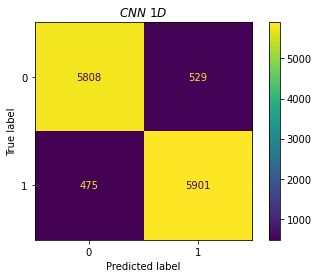

In [39]:
cnn1d_disp = ConfusionMatrixDisplay(cnn1d_cm)
cnn1d_disp.plot()
plt.title('$CNN~1D$')
plt.show()

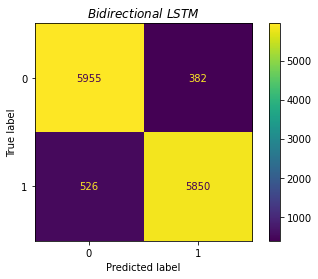

In [40]:
biLSTM_disp = ConfusionMatrixDisplay(biLSTM_cm)
biLSTM_disp.plot()
plt.title('$Bidirectional~LSTM $')
plt.show()

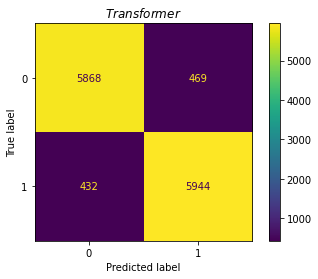

In [41]:
transformer_disp = ConfusionMatrixDisplay(transformer_cm)
transformer_disp.plot()
plt.title('$Transformer$')
plt.show()

## Exactitud

$$accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

In [42]:
def accuracy(confusion_matrix):
  cm = confusion_matrix
  acc = (cm[0,0]+cm[1,1])/np.sum(cm)
  return acc

In [43]:
print("Exactitud en la Red Neuronal Convolucional 1D: %"+str((accuracy(cnn1d_cm)*100)))
print("Exactitud en Bidirectional LSTM : %"+str((accuracy(biLSTM_cm)*100)))
print("Exactitud en Transformer: %"+str((accuracy(transformer_cm)*100)))

Exactitud en la Red Neuronal Convolucional 1D: %92.10257217021946
Exactitud en Bidirectional LSTM : %92.85770471171242
Exactitud en Transformer: %92.91276645952962


## F1 Score

$$F1 = \frac{TP}{TP+\frac{1}{2}(FP+FN)}$$

In [44]:
def f1_score(confusion_matrix):
  cm = confusion_matrix
  f1 = cm[1,1]/(cm[1,1]+0.5*(cm[0,1]+cm[1,0]))
  return f1

In [45]:
print("F1 Score en la Red Neuronal Convolucional 1D: "+str((f1_score(cnn1d_cm)*100)))
print("F1 Score en Bidirectional LSTM : "+str((f1_score(biLSTM_cm)*100)))
print("F1 Score en Transformer: "+str((f1_score(transformer_cm)*100)))

F1 Score en la Red Neuronal Convolucional 1D: 92.15992503513978
F1 Score en Bidirectional LSTM : 92.7982233502538
F1 Score en Transformer: 92.95488310266636


## Recall

$$recall = \frac{TP}{TP+FN}$$

In [46]:
def recall(confusion_matrix):
  cm = confusion_matrix
  r = cm[1,1]/(cm[1,1]+cm[1,0])
  return r

In [47]:
print("Recall en la Red Neuronal Convolucional 1D: "+str((recall(cnn1d_cm)*100)))
print("Recall en Bidirectional LSTM : "+str((recall(biLSTM_cm)*100)))
print("Recall en Transformer: "+str((recall(transformer_cm)*100)))

Recall en la Red Neuronal Convolucional 1D: 92.55018820577165
Recall en Bidirectional LSTM : 91.75031367628608
Recall en Transformer: 93.2245922208281


## Exactitud y pérdida en el entrenamiento

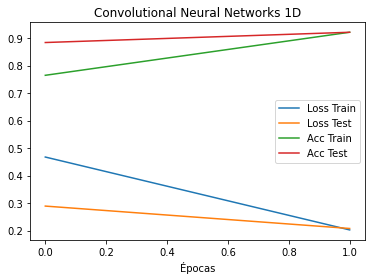

In [48]:
import matplotlib.pyplot as plt

plt.plot(history_cnn1d.history["loss"], label = "Loss Train")
plt.plot(history_cnn1d.history["val_loss"], label = "Loss Test")
plt.plot(history_cnn1d.history["accuracy"], label = "Acc Train")
plt.plot(history_cnn1d.history["val_accuracy"], label = "Acc Test")
plt.title('Convolutional Neural Networks 1D')
plt.xlabel('Épocas')
plt.legend()
plt.show()

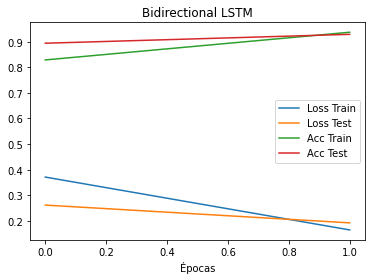

In [49]:
plt.plot(history_biLSTM.history["loss"], label = "Loss Train")
plt.plot(history_biLSTM.history["val_loss"], label = "Loss Test")
plt.plot(history_biLSTM.history["accuracy"], label = "Acc Train")
plt.plot(history_biLSTM.history["val_accuracy"], label = "Acc Test")
plt.title('Bidirectional LSTM')
plt.xlabel('Épocas')
plt.legend()
plt.show()

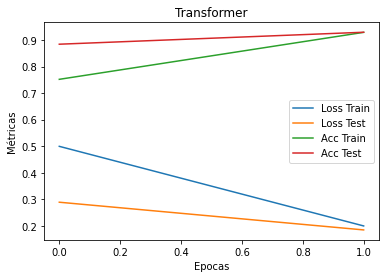

In [50]:
plt.plot(transformer_history.history["loss"], label="Loss Train")
plt.plot(transformer_history.history["val_loss"], label="Loss Test")
plt.plot(transformer_history.history["accuracy"], label="Acc Train")
plt.plot(transformer_history.history["val_accuracy"], label="Acc Test")
plt.title('Transformer')
plt.ylabel('Métricas')
plt.xlabel('Epocas')
plt.legend(loc='best')
plt.show()